| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This Jupyter Notebook is licensed under GPL 3.0. Please visit our Github organization for more information:  https://github.com/edgi-govdata-archiving/
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue.
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

# Who's responsible for greenhouse gas emissions?
Under the US Environmental Protection Agency's Greenhouse Gas Reporting Program (GHGRP), a variety of emitters are required to count and report their emissions anually.

Conceptually this is similar to reporting pollutant discharages under the Clean Water Act's National Pollutant Discharge Elimination System (NPDES), but whereas NPDES has legal teeth - facilities are permitted to release only so much of a pollutant into the water - there is no such equivalent legislation for greenhouse gases (GHGs).

Facilities reporting GHGs are also required to report information about ownership - the share a parent company has in the facility. Through this information we can determine not just which specific facilities reported the most GHGs every year, but which companies can be said to be the most responsible in terms of their ownership of these facilities.

The GHGRP does not attempt to account for all of the US's GHG emissions; the [GHG Inventory](https://www.epa.gov/ghgemissions/inventory-us-greenhouse-gas-emissions-and-sinks) does that. But GHGRP focuses on industrial direct emitters and some suppliers above certain thresholds. As EPA notes, "The GHGRP does not represent total U.S. GHG emissions, but provides facility level data for large sources of direct emissions, thus representing the majority of U.S. GHG emissions. The GHGRP data collected from direct emitters represent about half of all U.S. emissions." Including estimates from suppliers of fossil fuels, the GHGRP dataset [can account for](https://www.epa.gov/ghgreporting/learn-about-greenhouse-gas-reporting-program-ghgrp) up to 90% of all US emissions.

As EPA [notes](https://ccdsupport.com/confluence/pages/viewpage.action?pageId=98598976), "Data from direct emitters and suppliers cannot be viewed together because it would cause double counting of emissions in many sectors.  In general, it is more accurate to look at upstream (also called suppliers) data separately from downstream (also called direct emitters) data." EPA [elaborates](https://ccdsupport.com/confluence/pages/viewpage.action?pageId=98598975) on the differences between direct emitters and suppliers:

> "Direct emitters" are facilities that combust fuels or otherwise put GHGs into the atmosphere directly from their facility.  An example of this is a power plant that burns coal or natural gas and emits carbon dioxide directly into the atmosphere...."Suppliers" are those entities that supply products into the economy which if combusted, released or oxidized emit greenhouse gases into the atmosphere.  These fuels and industrial gases are not emitted from the supplier facility but instead distributed throughout the country and used.  An example of this is gasoline, which is sold in the U.S. and primarily burned in cars throughout the country."

This notebook uses self-reported data from both emitters and suppliers to estimate GHG emissions by parent company. For further information about how the EPA's GHGRP works, please see our PowerPoint slides [here](https://docs.google.com/presentation/d/1EVtWOFDEeaqZhg1FTf0IsEL3M736hITP5G76q9l6bP0/edit?usp=sharing) or the EPA's website [here](https://www.epa.gov/ghgreporting). For a full FAQ, see EPA's [helpdesk](https://ccdsupport.com/confluence/display/faq/GHG+Data+and+Publication).

# Setup
Here we load some helper code to get us going. Run the following cell of code. When it says "Done!" proceed to the next step.

In [1]:
# Import code libraries
import pandas as pd
import requests, zipfile, io
import geopandas
from IPython.core.display import HTML
import ipywidgets as widgets
!pip install pyxlsb &>/dev/null;
import pyxlsb
!pip install ECHO_modules &>/dev/null;

import warnings
warnings.filterwarnings('ignore')

print("Done!")

Done!


# Getting emissions data

Pick which year you want to focus on. Run the cell of code, choose a year from the dropdown menu, and then proceed to the next step.

In [2]:
years = ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]

years_dropdown = widgets.Dropdown(
  options = years,
  value = '2023',
  description='Year:',
  disabled=False
)

display(years_dropdown)

Dropdown(description='Year:', index=7, options=('2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'…

We will "download" EPA's emissions data for that year into this notebook.

In [5]:
# First we request EPA's datafile and unzip it.
url = "https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip"
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.79 Safari/537.36', # Pretend we are a normal browser
    'From': 'enost@uoguelph.ca'
}
r = requests.get(url, headers=headers)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content")

# We will load in the sheets in the unzipped XLSX file that contain various kinds of direct emissions, from individual facilities and sectors/activities
year = years_dropdown.value
ghg_fac = pd.read_excel("/content/ghgp_data_"+year+".xlsx",
  skiprows = 1, # skip the first two rows, which are irrelevant
  header = 2, # the third row represents the header
  converters={'Primary NAICS Code':str}, # read the NAICS codes as strings
  sheet_name = ["Direct Point Emitters", "Onshore Oil & Gas Prod.", "Gathering & Boosting",
    "Transmission Pipelines", "LDC - Direct Emissions", "SF6 from Elec. Equip.", "Suppliers"])

# We will also load in a file that tells us about the type of industry each facility is classified as
# Note that we use 2022 codes, which may lead to some anachronisms
naics = pd.read_excel("https://www.census.gov/naics/2022NAICS/6-digit_2022_Codes.xlsx",
  header = 0, # the row that represents the header
  converters={'2022 NAICS Code':str,'2022 NAICS Title':str}
)
naics=naics[["2022 NAICS Code", "2022 NAICS Title"]]

print("Data loaded!")

Data loaded!


The emissions data are presented in several different sections of EPA's spreadsheet, so here we compile them all together.

Emissions are measured in metric tons of CO2 equivalent, or tCO2e (see: https://www.theguardian.com/environment/2011/apr/27/co2e-global-warming-potential)

As output, we'll show the top 10 direct emitters and the top 10 suppliers.

In [11]:
# First, handle suppliers separately
# Treat NaNs as zeros (not reported, maybe not emitted)
# Skip "confidential" values :(
ghg_fac["Suppliers"]["Emissions (tCO2e)"] = pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Coal-based liquid fuel production"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Produced"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Imported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Exported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Liquids Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with CO2 Supply "], errors='coerce').fillna(0)

emissions_field_names = {
    "Direct Point Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use"
}

# Create a new DataFrame to store emissions data compiled from direct emitters
fac_directemitters_data = pd.DataFrame([], columns=["Facility", "Name", "Primary NAICS Code", "Emissions (tCO2e)"])
# Do the same for suppliers
fac_suppliers_data = pd.DataFrame(ghg_fac["Suppliers"])

#Compile emissions data across direct emitters.
for key in emissions_field_names.keys():
  dump = ghg_fac[key]
  dump = dump[["Facility Id", "Facility Name", "Primary NAICS Code", emissions_field_names[key]]]
  dump = dump.rename(columns={"Facility Id": "Facility", "Facility Name": "Name", "Primary NAICS Code": "2022 NAICS Code", emissions_field_names[key]:"Emissions (tCO2e)"})
  dump["Emissions (tCO2e)"] = pd.to_numeric(dump["Emissions (tCO2e)"])
  fac_directemitters_data= pd.concat([fac_directemitters_data,dump])

# Roll up duplicate facility IDs (facilities with e.g. both direct emissions and onshore oil...)
fac_directemitters_data = fac_directemitters_data.groupby(by=["Facility", "Name", "2022 NAICS Code"]).sum().reset_index() #For presentation purposes, we'll add in the facility name
#fac_directemitters_data = fac_directemitters_data.groupby(by=["Facility"]).sum() # For analysis purposes, we'll leave the name off...it'll get added back in when we add it to the parent company table
fac_suppliers_data=fac_suppliers_data.rename(columns={"Facility Id": "Facility", "Facility Name": "Name", "Primary NAICS Code": "2022 NAICS Code"})
fac_suppliers_data = fac_suppliers_data[["Facility", "Name", "2022 NAICS Code", "Emissions (tCO2e)"]]
fac_directemitters_data['2022 NAICS Code']=fac_directemitters_data['2022 NAICS Code'].astype(str)

# Look up industry information
fac_directemitters_data = fac_directemitters_data.merge(naics, on="2022 NAICS Code")
fac_suppliers_data = fac_suppliers_data.merge(naics, on="2022 NAICS Code")

# Display emitters and suppliers data
display(HTML("<h2>"+year+"'s Top 10 Direct Emitters:</h2>"))
display(fac_directemitters_data.nlargest(10,"Emissions (tCO2e)").style.format({"Emissions (tCO2e)": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Top 10 Supplier Facilities:</h2>"))
display(fac_suppliers_data.nlargest(10,"Emissions (tCO2e)").style.format({"Emissions (tCO2e)": '{:,.0f}'}))

,Facility,Name,2022 NAICS Code,Primary NAICS Code,Emissions (tCO2e),2022 NAICS Title
4597,1007227,James H Miller Jr,221112,0,"16,558,381",Fossil Fuel Electric Power Generation
149,1000192,Labadie,221112,0,"15,388,715",Fossil Fuel Electric Power Generation
793,1001194,Gen J M Gavin,221112,0,"13,451,174",Fossil Fuel Electric Power Generation
4738,1007504,Martin Lake,221112,0,"12,787,949",Fossil Fuel Electric Power Generation
4760,1007542,EXXONMOBIL Bt Site,324110,0,"12,693,547",Petroleum Refineries
4739,1007505,Oak Grove,221112,0,"12,278,594",Fossil Fuel Electric Power Generation
1251,1001887,PRAIRIE STATE GENERATING STATION,221112,0,"11,456,295",Fossil Fuel Electric Power Generation
465,1000676,Monroe,221112,0,"11,413,347",Fossil Fuel Electric Power Generation
4945,1007793,Harrison Power Station,221112,0,"11,179,958",Fossil Fuel Electric Power Generation
681,1001045,Laramie River,221112,0,"10,979,532",Fossil Fuel Electric Power Generation


,Facility,Name,2022 NAICS Code,Emissions (tCO2e),2022 NAICS Title
990,1010568,Valero Marketing and Supply Company,424720,"238,380,354",Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)
414,1003043,Garyville Refinery,324110,"93,705,370",Petroleum Refineries
582,1007458,MOTIVA ENTERPRISES LLC,324110,"91,983,868",Petroleum Refineries
351,1007959,Exxonmobil Beaumont Refinery,324110,"83,078,905",Petroleum Refineries
331,1007542,EXXONMOBIL Bt Site,324110,"82,201,241",Petroleum Refineries
330,1007643,EXXONMOBIL BATON ROUGE REFINERY AND CHEMICAL PLANT,324110,"80,977,604",Petroleum Refineries
347,1010448,Enterprise Products Operating LLC,488320,"72,902,210",Marine Cargo Handling
412,1005585,Galveston Bay Refinery,324110,"71,172,513",Petroleum Refineries
94,1007339,BP Whiting Business Unit,324110,"65,956,897",Petroleum Refineries
152,1002389,CITGO PETROLEUM CORP - LAKE CHARLES MANUFACTURING COMPLEX,324110,"64,197,374",Petroleum Refineries


Export this processed data, if you like, by running the cell below.


In [12]:
if ( fac_directemitters_data is not None):
  fac_directemitters_data.to_csv( 'ghgdata_directemitters_facilities_'+year+'.csv' )
if ( fac_suppliers_data is not None):
  fac_suppliers_data.to_csv( 'ghgdata_suppliers_facilities_'+year+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


Now we'll get EPA's information on who owns these facilities.

In [13]:
# First we get some additional information from the EPA on parent companies
url = "https://www.epa.gov/system/files/other-files/2024-10/ghgp_data_parent_company.xlsb"
r = requests.get(url, headers=headers) # Pretend we are a normal browser
parents = pd.read_excel(r.content, engine='pyxlsb', sheet_name = year)
parents["PARENT COMPANY NAME"] = parents["PARENT COMPANY NAME"].str.upper() # Standardize company names to uppercase - sometimes EPA allows company names to be reported in upper and lower case, which intereferes with our ability to aggregate them
parents

,GHGRP FACILITY ID,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
0,1000001,1.100005e+11,2023,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,Po Box 97034,Bellevue,WA,98009,100.0,221112.0
1,1000002,1.100412e+11,2023,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,"10194 Crosspoint Blvd, Suite 410",Indianapolis,IN,46256,100.0,327213.0
2,1000003,1.100015e+11,2023,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,10194 CROSSPOINT BLVD STE 410,Indianapolis,IN,46256,100.0,327213.0
3,1000005,1.100005e+11,2023,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,10194 CROSSPOINT BLVD STE 410,Indianapolis,IN,46256,100.0,327213.0
4,1000007,1.100070e+11,2023,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,"5960 Berkshire Lane, Suite 900",Dallas,TX,75225,100.0,327420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055,1014921,1.100717e+11,2023,Avista Landfill,NaN,Kettle Falls,WA,99141,STEVENS COUNTY,AVISTA CORP,1411 E Mission Ave,Spokane,WA,99202,100.0,562212.0
9056,1015119,1.100575e+11,2023,VMC Specialty Alloys LLC,800 Martin Luther King Jr Drive,Adairsville,GA,30103,BARTOW COUNTY,VMC SPECIALTY ALLOYS LLC,800 Martin Luther King Drive,Adairsville,GA,30103,100.0,331314.0
9057,1015125,1.100283e+11,2023,Blue Flint Capture Company,2841 3rd St SW,Underwood,ND,58576,MCLEAN COUNTY,HARVESTONE LOW CARBON PARTNERS,2841 3rd Street SW,Underwood,ND,58576,100.0,325120.0
9058,1015127,NaN,2023,Kronospan Simsboro LLC,486 Duraflake Road,Simsboro,LA,71275,NaN,KRONOSPAN INC,1 Kronospan Way,Eastaboga,AL,36260,100.0,321219.0


In this cell, we'll pair parent companies' data with that of the facilities they own.

In [14]:
# Join tables between Facility and GHGRP FACILITY ID
# Basically we are saying, for each facility, and for each parent/stake, what emissions?
# First we'll join in all emissions, then later we'll account for specific percent ownership and reduce emissions according to these stakes.
join_emitters = fac_directemitters_data.set_index("Facility").join(parents.set_index('GHGRP FACILITY ID'))
join_suppliers = fac_suppliers_data.set_index("Facility").join(parents.set_index('GHGRP FACILITY ID'))

# Show the first few lines of data from each
display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(join_emitters.head(5))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(join_suppliers.head(5))

,Name,2022 NAICS Code,Primary NAICS Code,Emissions (tCO2e),2022 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
1000001,PSE Ferndale Generating Station,221112,0,715257.160,Fossil Fuel Electric Power Generation,1.100005e+11,2023.0,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248.0,WHATCOM COUNTY,PUGET HOLDINGS LLC,Po Box 97034,Bellevue,WA,98009,100.0,221112.0
1000002,Ardagh Glass Inc. (Dunkirk),327213,0,116955.040,Glass Container Manufacturing,1.100412e+11,2023.0,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336.0,JAY COUNTY,ARDAGH GLASS INC,"10194 Crosspoint Blvd, Suite 410",Indianapolis,IN,46256,100.0,327213.0
1000003,Ardagh Glass Inc. (Henderson),327213,0,77625.440,Glass Container Manufacturing,1.100015e+11,2023.0,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537.0,VANCE COUNTY,ARDAGH GLASS INC,10194 CROSSPOINT BLVD STE 410,Indianapolis,IN,46256,100.0,327213.0
1000005,Ardagh Glass Inc. (Madera),327213,0,71574.356,Glass Container Manufacturing,1.100005e+11,2023.0,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637.0,MADERA COUNTY,ARDAGH GLASS INC,10194 CROSSPOINT BLVD STE 410,Indianapolis,IN,46256,100.0,327213.0
1000007,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,327420,0,15755.340,Gypsum Product Manufacturing,1.100070e+11,2023.0,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004.0,SANDOVAL COUNTY,EAGLE MATERIALS INC,"5960 Berkshire Lane, Suite 900",Dallas,TX,75225,100.0,327420.0


,Name,2022 NAICS Code,Emissions (tCO2e),2022 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
Facility,,,,,,,,,,,,,,,,,,,
1013701,30-30 Gas Plant,211130,0.0,Natural Gas Extraction,1.100709e+11,2023,30-30 Gas Plant,2300 FM 1622,Plains,TX,79355,YOAKUM COUNTY,STAKEHOLDER GAS SERVICES LLC,19122 US HWY 281 N Suite 113,San Antonio,TX,78258,100.0,211130.0
1002574,3M COMPANY,339999,0.0,All Other Miscellaneous Manufacturing,1.100708e+11,2023,3M COMPANY,3M CENTER,ST PAUL,MN,55144,RAMSEY COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,339999.0
1006665,3M Chemical Operations' Cordova Facility,325998,0.0,All Other Miscellaneous Chemical Product and P...,1.100139e+11,2023,3M Chemical Operations' Cordova Facility,22614 ROUTE 84 NORTH,CORDOVA,IL,61242,ROCK ISLAND COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,325998.0
1004836,3M Chemical Operations' Cottage Grove Facility,325998,0.0,All Other Miscellaneous Chemical Product and P...,1.100004e+11,2023,3M Chemical Operations' Cottage Grove Facility,10746 Innovation Rd,Cottage Grove,MN,55016,WASHINGTON COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,325998.0
1004206,3M Chemical Operations' Decatur Facility,325211,0.0,Plastics Material and Resin Manufacturing,1.100004e+11,2023,3M Chemical Operations' Decatur Facility,1400 STATE DOCKS RD.,DECATUR,AL,35609,MORGAN COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,325211.0


Here we'll show and remove the facilities/parents that have no reported emissions.

We remove them because we don't want to end up having to convert their values to 0 and suggesting those facilities/companies have no actual emissions when they just have no *reported* emissions.

In [15]:
nas_e = join_emitters.loc[join_emitters["Emissions (tCO2e)"] == 0]
join_emitters = join_emitters.drop(nas_e.index)

# For suppliers
nas_s = join_suppliers.loc[join_suppliers["Emissions (tCO2e)"]  == 0]
join_suppliers = join_suppliers.drop(nas_s.index)

# Show the first few lines of data from each
display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(nas_e.head(5))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(nas_s.head(5))

,Name,2022 NAICS Code,Primary NAICS Code,Emissions (tCO2e),2022 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
1000567,Ravenswood Steam Plant,221330,0,0.0,Steam and Air-Conditioning Supply,1.100331e+11,2023.0,Ravenswood Steam Plant,38-54 Vernon Blvd,Long Island City,NY,11101.0,Queens,CONSOLIDATED EDISON INC,4 Irving Place,New York,NY,10003,100.0,221330.0
1000707,Meramec,221112,0,0.0,Fossil Fuel Electric Power Generation,1.100020e+11,2023.0,Meramec,8200 FINE RD,ST LOUIS,MO,63129.0,Saint Louis,AMEREN CORP,1901 Chouteau Avenue,St. Louis,MO,63101,100.0,221112.0
1001022,"Somerset Operating Compnay, LLC",221112,0,0.0,Fossil Fuel Electric Power Generation,1.100003e+11,2023.0,"Somerset Operating Compnay, LLC",7725 LAKE ROAD,BARKER,NY,14012.0,Niagara,HEOROT POWER HOLDINGS LLC,9 Federal Street,Easton,MD,21601,100.0,221112.0
1001419,Escalante,221112,0,0.0,Fossil Fuel Electric Power Generation,1.100008e+11,2023.0,Escalante,COUNTY ROAD 19,PREWITT,NM,87045.0,McKinley,TRI-STATE GENERATION & TRANSMISSION ASSOC INC,1100 W. 116th Avenue,Westminster,CO,80234,100.0,221112.0
1001515,"Grand Tower Energy Center, LLC",221112,0,0.0,Fossil Fuel Electric Power Generation,1.100420e+11,2023.0,"Grand Tower Energy Center, LLC",1820 POWER PLANT ROAD,GRAND TOWER,IL,62942.0,Jackson,ROCKLAND CAPITAL LLC,"24 Waterway Avenue, Suite 400",Spring,TX,77380,100.0,221112.0


,Name,2022 NAICS Code,Emissions (tCO2e),2022 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
Facility,,,,,,,,,,,,,,,,,,,
1013701,30-30 Gas Plant,211130,0.0,Natural Gas Extraction,1.100709e+11,2023,30-30 Gas Plant,2300 FM 1622,Plains,TX,79355,YOAKUM COUNTY,STAKEHOLDER GAS SERVICES LLC,19122 US HWY 281 N Suite 113,San Antonio,TX,78258,100.0,211130.0
1002574,3M COMPANY,339999,0.0,All Other Miscellaneous Manufacturing,1.100708e+11,2023,3M COMPANY,3M CENTER,ST PAUL,MN,55144,RAMSEY COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,339999.0
1006665,3M Chemical Operations' Cordova Facility,325998,0.0,All Other Miscellaneous Chemical Product and P...,1.100139e+11,2023,3M Chemical Operations' Cordova Facility,22614 ROUTE 84 NORTH,CORDOVA,IL,61242,ROCK ISLAND COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,325998.0
1004836,3M Chemical Operations' Cottage Grove Facility,325998,0.0,All Other Miscellaneous Chemical Product and P...,1.100004e+11,2023,3M Chemical Operations' Cottage Grove Facility,10746 Innovation Rd,Cottage Grove,MN,55016,WASHINGTON COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,325998.0
1004206,3M Chemical Operations' Decatur Facility,325211,0.0,Plastics Material and Resin Manufacturing,1.100004e+11,2023,3M Chemical Operations' Decatur Facility,1400 STATE DOCKS RD.,DECATUR,AL,35609,MORGAN COUNTY,3M CO,3M Center,St. Paul,MN,55144-1000,100.0,325211.0


Finally, we'll calculate parent companies' emissions responsibility based on percent ownership.

Some companies have less than 100% ownership of a given facility - they share ownership with other entities. We divide a facility's emissions between all owners according to their percent share.

In [16]:
# PARENT SHARE = for each facility, and for each owner, how many of that facility's emissions was that owner responsible for based on percent ownership.
join_emitters["PARENT EMISSIONS AMT"] = join_emitters['Emissions (tCO2e)'] * join_emitters["PARENT CO. PERCENT OWNERSHIP"] / 100
join_suppliers["PARENT EMISSIONS AMT"] = join_suppliers['Emissions (tCO2e)'] * join_suppliers["PARENT CO. PERCENT OWNERSHIP"] / 100

# Show the first few lines of data from each
display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(join_emitters.head(5))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(join_suppliers.head(5))

,Name,2022 NAICS Code,Primary NAICS Code,Emissions (tCO2e),2022 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,...,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,PARENT EMISSIONS AMT
1000001,PSE Ferndale Generating Station,221112,0,715257.160,Fossil Fuel Electric Power Generation,1.100005e+11,2023.0,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,...,98248.0,WHATCOM COUNTY,PUGET HOLDINGS LLC,Po Box 97034,Bellevue,WA,98009,100.0,221112.0,715257.160
1000002,Ardagh Glass Inc. (Dunkirk),327213,0,116955.040,Glass Container Manufacturing,1.100412e+11,2023.0,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,...,47336.0,JAY COUNTY,ARDAGH GLASS INC,"10194 Crosspoint Blvd, Suite 410",Indianapolis,IN,46256,100.0,327213.0,116955.040
1000003,Ardagh Glass Inc. (Henderson),327213,0,77625.440,Glass Container Manufacturing,1.100015e+11,2023.0,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,...,27537.0,VANCE COUNTY,ARDAGH GLASS INC,10194 CROSSPOINT BLVD STE 410,Indianapolis,IN,46256,100.0,327213.0,77625.440
1000005,Ardagh Glass Inc. (Madera),327213,0,71574.356,Glass Container Manufacturing,1.100005e+11,2023.0,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,...,93637.0,MADERA COUNTY,ARDAGH GLASS INC,10194 CROSSPOINT BLVD STE 410,Indianapolis,IN,46256,100.0,327213.0,71574.356
1000007,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,327420,0,15755.340,Gypsum Product Manufacturing,1.100070e+11,2023.0,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,...,87004.0,SANDOVAL COUNTY,EAGLE MATERIALS INC,"5960 Berkshire Lane, Suite 900",Dallas,TX,75225,100.0,327420.0,15755.340


,Name,2022 NAICS Code,Emissions (tCO2e),2022 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,PARENT EMISSIONS AMT
Facility,,,,,,,,,,,,,,,,,,,,
1007622,ALON REFINING KROTZ SPRINGS INC,324110,1.114821e+07,Petroleum Refineries,1.100410e+11,2023,ALON REFINING KROTZ SPRINGS INC,356 S. LEVEE RD,KROTZ SPRINGS,LA,70750,ST. LANDRY PARISH,DELEK US HOLDINGS INC,"310 Seven Springs Way, Suite 500",Brentwood,TN,37027,100.0,324110.0,1.114821e+07
1005590,AMERICAN REFINING GROUP INC,324110,1.238886e+06,Petroleum Refineries,1.100003e+11,2023,AMERICAN REFINING GROUP INC,77 NORTH KENDALL AVENUE,BRADFORD,PA,16701,MCKEAN COUNTY,AMERICAN REFINING GROUP INC,"100 Four Falls Corporate Center, Suite 215",West Conshohocken,PA,19428-2960,100.0,324110.0,1.238886e+06
1010594,AMERICAN REFINING GROUP INC - IMPORT/EXPORT,324110,8.644564e+04,Petroleum Refineries,NaN,2023,AMERICAN REFINING GROUP INC - IMPORT/EXPORT,77 NORTH KENDALL AVE,BRADFORD,PA,16701,NaN,AMERICAN REFINING GROUP INC,"100 Four Falls Corporate Center, Suite 215",West Conshohocken,PA,19428-2960,100.0,324110.0,8.644564e+04
1014835,ARAMCO TRADING AMERICAS LLC,424720,1.760334e+07,Petroleum and Petroleum Products Merchant Whol...,NaN,2023,ARAMCO TRADING AMERICAS LLC,500 DALLAS STREET,HOUSTON,TX,77002,NaN,ARAMCO TRADING AMERICAS LLC,500 Dallas Street,Houston,TX,77002,100.0,424720.0,1.760334e+07
1004285,AUSTIN UTILITIES,221210,1.386906e+05,Natural Gas Distribution,1.100712e+11,2023,AUSTIN UTILITIES,1908 14th St NE,AUSTIN,MN,55912,MOWER COUNTY,CITY OF AUSTIN MINNESOTA,400 Fourth Street Ne,Austin,MN,55912,100.0,221210.0,1.386906e+05


In this last step of data preparation, we summarize emissions by parent company across facilities.

A major assumption here is that parent company names are standardized in EPA's database.

We show the top ten parent companies in terms of emissions.

Re-run the cell below and change `number = 10` to some other number than 10 to see more of the ranking.

In [17]:
summary_e = join_emitters.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])
summary_s = join_suppliers.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])

number = 10

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(summary_e["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(number, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(summary_s["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(number, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))

,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,
VISTRA CORP,"86,320,993",40
THE SOUTHERN CO,"76,718,005",54
DUKE ENERGY CORP,"72,776,123",49
BERKSHIRE HATHAWAY INC,"53,055,963",128
AMERICAN ELECTRIC POWER CO INC,"48,971,843",26
CPN MANAGEMENT LP,"47,703,517",44
NEXTERA ENERGY INC,"42,867,570",27
ENTERGY CORP,"38,142,109",30
EXXON MOBIL CORP,"37,882,422",59


,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,
VALERO ENERGY CORP,"511,680,742",15
MARATHON PETROLEUM CORP,"437,065,133",17
PHILLIPS 66,"346,616,539",19
EXXON MOBIL CORP,"341,759,108",10
ENTERPRISE PRODUCTS PARTNERS LP,"196,807,286",17
CHEVRON CORP,"164,470,509",5
BP AMERICA INC,"142,190,500",5
PDV AMERICA INC,"122,786,461",5
PBF ENERGY INC,"107,787,144",7


Export this processed data, if you like, by running the cell below.


In [18]:
if ( summary_e is not None):
  summary_e.to_csv( 'ghgdata_directemitters_companies_'+year+'.csv' )
if ( summary_s is not None):
  summary_s.to_csv( 'ghgdata_suppliers_companies_'+year+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


What share of all US emissions covered under EPA's GHGRP do these corporations account for? (See similar measurements done for the entire world and for several decades: https://climateaccountability.org/carbonmajors_dataset2020.html)

In [19]:
summary_e = join_emitters.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].sum()
summary_s = join_suppliers.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].sum()

number = 10

result_e = (summary_e.nlargest(number, "PARENT EMISSIONS AMT").sum() / summary_e["PARENT EMISSIONS AMT"].sum()) * 100
result_s = (summary_s.nlargest(number, "PARENT EMISSIONS AMT").sum() / summary_s["PARENT EMISSIONS AMT"].sum()) * 100

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display('The top '+str(number)+' companies account for {:,.0f}'.format(result_e["PARENT EMISSIONS AMT"]) + "% of emissions")
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display('The top '+str(number)+' companies account for {:,.0f}'.format(result_s["PARENT EMISSIONS AMT"]) + "% of emissions")

'The top 10 companies account for 21% of emissions'

'The top 10 companies account for 53% of emissions'

How many companies account for ~50% of US emissions reported under GHGRP? By adjusting the number in `nlargest(#)` we can see that the 50 largest companies account for ~50% of reported direct emissions while just the 10 largest suppliers account for ~50% of emissions.

In [20]:
result_e = (summary_e.nlargest(50, "PARENT EMISSIONS AMT").sum() / summary_e["PARENT EMISSIONS AMT"].sum()) * 100
result_s = (summary_s.nlargest(10, "PARENT EMISSIONS AMT").sum() / summary_s["PARENT EMISSIONS AMT"].sum()) * 100

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display('The top 50 companies account for {:,.0f}'.format(result_e["PARENT EMISSIONS AMT"]) + "% of emissions")
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display('The top 10 companies account for {:,.0f}'.format(result_s["PARENT EMISSIONS AMT"]) + "% of emissions")

'The top 50 companies account for 49% of emissions'

'The top 10 companies account for 53% of emissions'

# Analyze
In this section, we'll start analying the data on corporate emissions. First, by looking at specific states and even counties. Then, nationwide.

## State and County-Level Trends

We'll illustrate the top polluting companies based on owned facilities within a specific state or even county.

First, choose whether to focus on direct emitters or suppliers.

In [21]:
t = widgets.RadioButtons(
    options=['Emitters', 'Suppliers'],
    description='Type: ',
    disabled=False
)
display(t)

RadioButtons(description='Type: ', options=('Emitters', 'Suppliers'), value='Emitters')

Then, choose a state:

In [22]:
if t.value == "Emitters":
  states = list(join_emitters['FACILITY STATE'].unique())
  states = [x for x in states if str(x) != 'nan']
  states.sort()
  join = join_emitters
elif t.value == "Suppliers":
  states = list(join_suppliers['FACILITY STATE'].unique())
  states = [x for x in states if str(x) != 'nan']
  states.sort()
  join = join_suppliers

state_selection = widgets.Dropdown(
  options=states,
  description='Select a state:'
)
state_selection

Dropdown(description='Select a state:', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', '…

Next, we'll show the top ten parent companies in terms of direct or supplied emissions in this state.

Re-run the cell above to select a different state and then run this one again to see the new results. You can also change `geo_summary.nlargest(10, "PARENT EMISSIONS AMT")` to some other number than 10 to see more of the ranking.

In [23]:
# Filter the data to the selected state
geo_join = join.loc[join['FACILITY STATE'] == state_selection.value]
geo_summary = geo_join.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])

display(HTML("<h2>"+t.value+" in "+state_selection.value+" in "+year+"</h2>"))
display(geo_summary["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(10, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))

,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,
HILCORP ENERGY CO,"12,322,316",22
CONOCOPHILLIPS,"1,825,982",5
GOLDEN VALLEY ELECTRIC ASSOC INC,"876,837",2
CHUGACH ELECTRIC ASSOC INC,"802,119",4
MARATHON PETROLEUM CORP,"545,281",1
MATANUSKA ELECTRIC ASSOC INC,"337,966",1
AURORA ENERGY LLC,"265,496",1
ALYESKA PIPELINE SERVICE CO,"215,970",4
HOMER ELECTRIC ASSOC INC,"212,524",3


Export this processed data, if you like, by running the cell below.


In [24]:
if ( geo_summary is not None):
  geo_summary.to_csv( 'ghgdata_'+t.value+'_companies_'+year+'_'+state_selection.value+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


Do you want to look at the results for a specific county in the state you've chosen? If so, run the following two cells.

In [25]:
# Get and select counties
from ECHO_modules.utilities import show_pick_region_widget
county_selection = show_pick_region_widget("County", state_selection, multi = False)

Dropdown(description='County:', options=('ALASKA', 'ALEUTIAN ISLANDS', 'ALEUTIANS EAST', 'ALEUTIANS WEST', 'AN…

In [26]:
# Filter the data to the selected county or counties
join['FACILITY COUNTY'] = join['FACILITY COUNTY'].str.upper() # Standardize formatting
geo_join = join.loc[(join['FACILITY STATE'] == state_selection.value) & (join['FACILITY COUNTY'].str.contains(county_selection.value))]
geo_summary = geo_join.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count']) # Summarize ownership of facilities in this county/these counties

display(HTML("<h2>"+t.value+" in "+county_selection.value+", "+state_selection.value+" in "+year+"</h2>"))
display(geo_summary["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(10, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))

,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,
GOLDEN VALLEY ELECTRIC ASSOC INC,"269,151",1
AURORA ENERGY LLC,"265,496",1
DOYON LTD,"152,421",1
FAIRBANKS SEWER & WATER INC,"152,421",1
STATE OF ALASKA,"116,616",1
BOROUGH OF FAIRBANKS NORTH STAR,"82,673",1
ARCTIC SLOPE REGIONAL CORP,"35,598",1
US GOVERNMENT,0,0


Export this processed data, if you like, by running the cell below.


In [27]:
if ( geo_summary is not None):
  geo_summary.to_csv( 'ghgdata_'+t.value+'_companies_'+year+'_'+state_selection.value+'_'+county_selection.value+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


## National Trends

In what follows, we'll look at how different kinds of parent companies/owners stack up in terms of emissions *nationwide*. In other words, we'll look at different sectors of ownership: universities, municipalities (cities), etc.

Are American universities significant emitters of GHG emissions? What we'll do is search our list of facility owners to see if there are any with "university" or "university of" in their name. Please note that this dataset accounts only for direct ownership of GHG-emitting facilities - universities' stock in or divestment from GHG-emitting companies are not tracked.

Let's look at the top 10. Again, to see more of the ranking change ...`.nlargest(20, 'PARENT EMISSIONS AMT')` to some other number than 10.

In [28]:
e = summary_e.query("index.str.lower().str.contains('university')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')
s = summary_s.query("index.str.lower().str.contains('university')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(e.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(s.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
UNIVERSITY OF TEXAS SYSTEM,"364,436"
UNIVERSITY OF ILLINOIS,"335,851"
MICHIGAN STATE UNIVERSITY,"298,938"
THE REGENTS OF THE UNIVERSITY OF MICHIGAN,"272,741"
UNIVERSITY OF CINCINNATI,"172,058"
THE PENNSYLVANIA STATE UNIVERSITY,"165,461"
CORNELL UNIVERSITY,"148,240"
THE UNIVERSITY OF IOWA,"148,016"
IOWA STATE UNIVERSITY OF SCIENCE & TECHNOLOGY,"146,726"


,PARENT EMISSIONS AMT
PARENT COMPANY NAME,


You'll see that universities do not seem to directly own fossil fuel supplying facilities (e.g. refineries). Let's chart universities as direct emitters.

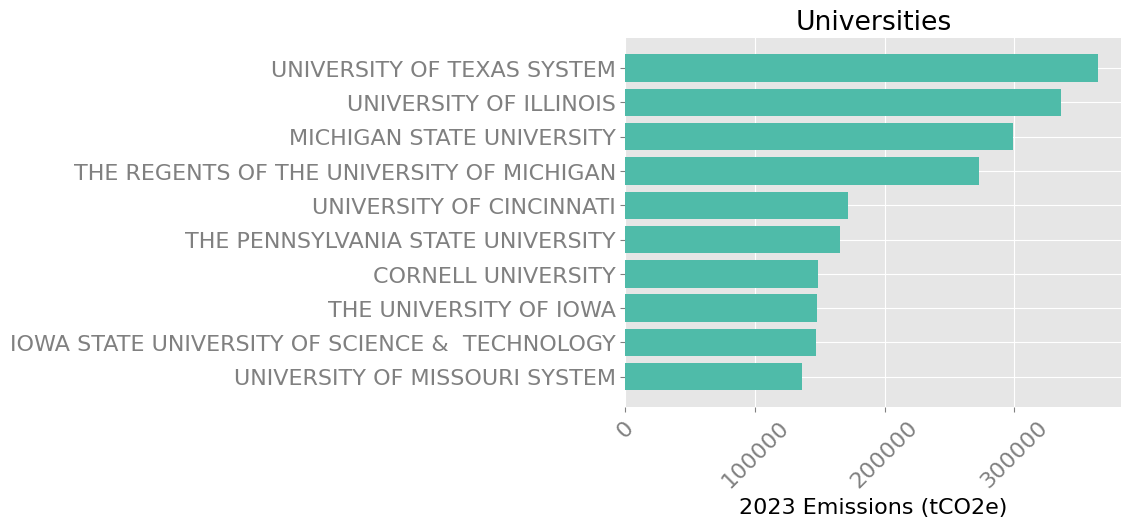

In [29]:
from ECHO_modules import utilities
def bar_chart(data, title):
  fig, ax = utilities.plt.subplots()
  ax.barh(utilities.np.arange(data.shape[0]), data["PARENT EMISSIONS AMT"])
  ax.set_yticks(utilities.np.arange(data.shape[0]))
  ax.set_yticklabels(list(data.index))
  ax.invert_yaxis()
  ax.set_xlabel(year+' Emissions (tCO2e)')
  ax.set_title(title)
  ax.ticklabel_format(axis = 'x', style='plain')
  utilities.plt.xticks(rotation=45)
  utilities.plt.show()
bar_chart(e, 'Universities')

In addition to some universities, cities too are publicly-controlled entities that may be key targets for GHG emissions reduction or divestment. How much do they emit? Which cities?

In [30]:
e = summary_e.query("index.str.lower().str.contains('city of')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')
s = summary_s.query("index.str.lower().str.contains('city of')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(e.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(s.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
CITY OF LOS ANGELES CALIFORNIA,"2,593,172"
CITY OF TALLAHASSEE FLORIDA,"1,298,558"
CITY OF GAINESVILLE FLORIDA,"922,200"
CITY OF LAKELAND FLORIDA,"821,581"
CITY WATER & LIGHT PLANT OF THE CITY OF JONESBORO ARKANSAS,"806,687"
CITY OF SPRINGFIELD ILLINOIS,"779,448"
CITY OF FREMONT NEBRASKA,"603,711"
CITY OF EL PASO TEXAS,"544,399"
CITY OF BATON ROUGE LOUISIANA,"508,923"


,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
CITY OF MEMPHIS TENNESSEE,"4,979,306"
CITY OF KINGS MOUNTAIN NORTH CAROLINA,"1,268,690"
CITY OF RICHMOND VIRGINIA,"1,166,985"
CITY OF CARROLLTON KENTUCKY,"618,342"
CITY OF LONG BEACH CALIFORNIA,"512,180"
BREWTON CITY OF (INC),"424,357"
CITY OF MADISON ALABAMA,"371,681"
CITY OF MUSCLE SHOALS ALABAMA,"371,681"
CITY OF DULUTH MINNESOTA,"360,130"


Here we'll create charts of this data.

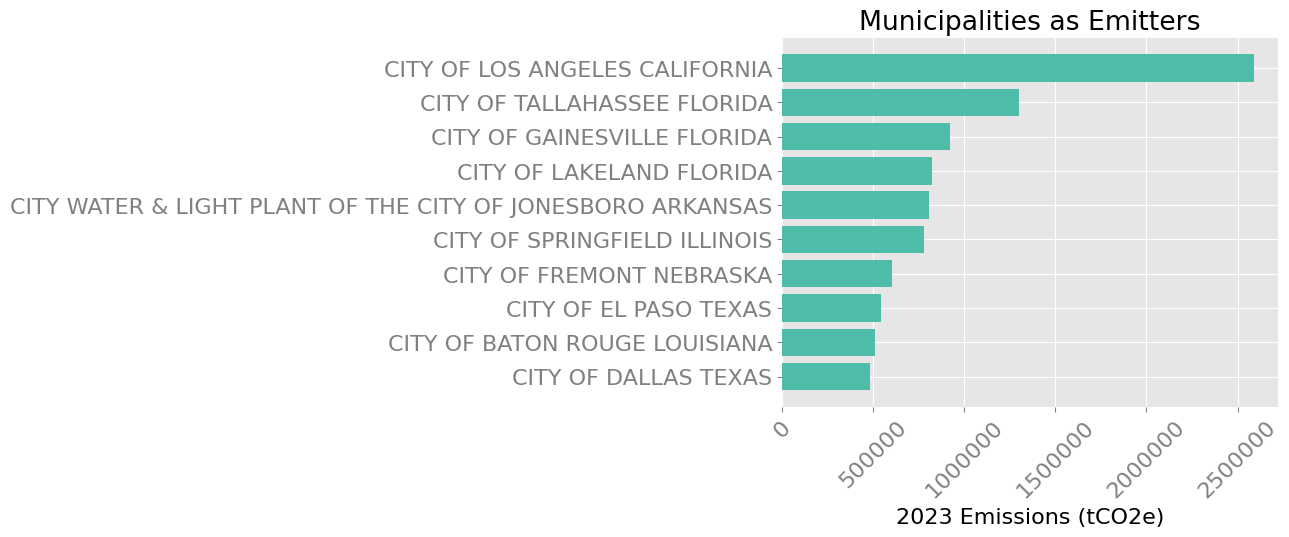

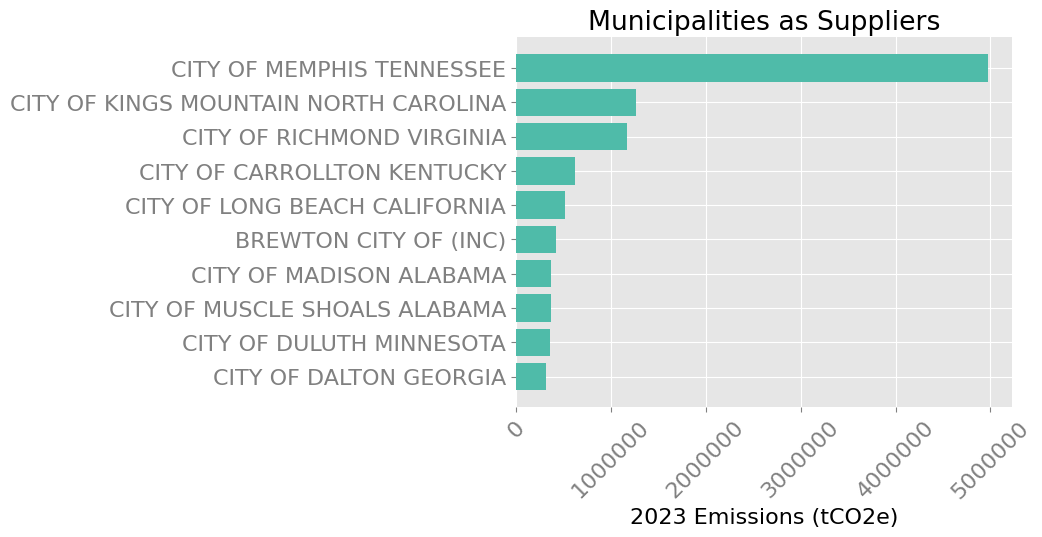

In [31]:
bar_chart(e, 'Municipalities as Emitters')
bar_chart(s, 'Municipalities as Suppliers')

You might be interested in exploring other kinds of entities (e.g. "Department of Defense")) or specific owners (e.g. "Koch Brothers", "Exxon", etc.) or entities associated with specific areas (e.g. "Chicago")

Run the following cell to produce a textbox where you can enter the specific term you want to search for.

In [32]:
search = widgets.Text(
  value='',
  placeholder='Type something here e.g. Exxon',
  description='Search:',
  disabled=False
)
display(search)

Text(value='', description='Search:', placeholder='Type something here e.g. Exxon')

Then run this cell to see the results!

In [33]:
e = summary_e.query("index.str.lower().str.contains('"+search.value.lower()+"')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

s = summary_s.query("index.str.lower().str.contains('"+search.value.lower()+"')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(e.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(s.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
EXXON MOBIL CORP,"37,882,422"


,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
EXXON MOBIL CORP,"341,759,108"
